In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
filter_dir = './deploy/filter'
classification_dir = './deploy/classifier'

In [31]:
from data.dataset import AnnotatedData
from train import *
d = AnnotatedData.load('data/senna')

y = []
for X, Y in d.generate_batches('test'):
    y.append(Y.argmax(axis=1))
from collections import Counter
print Counter(np.concatenate(y)).most_common()

[(1, 1071), (0, 480), (4, 228), (13, 172), (8, 129), (2, 109), (18, 98), (3, 88), (12, 85), (14, 78), (25, 76), (20, 72), (22, 68), (16, 60), (10, 55), (11, 55), (6, 50), (23, 39), (17, 33), (9, 25), (19, 22), (5, 21), (21, 20), (34, 19), (7, 18), (15, 18), (28, 17), (26, 14), (33, 9), (32, 8), (31, 7), (30, 6), (35, 6), (27, 5), (29, 4), (24, 3), (36, 3), (37, 2), (38, 1)]


In [32]:
import cPickle as pkl
with open(os.path.join(classification_dir, 'test.pkl')) as f:
    test = pkl.load(f)
print Counter(test['targ']).most_common()

[(1, 1071), (0, 480), (4, 228), (13, 172), (8, 129), (2, 109), (18, 98), (3, 88), (12, 85), (14, 78), (25, 76), (20, 72), (22, 68), (16, 60), (10, 55), (11, 55), (6, 50), (23, 39), (17, 33), (9, 25), (19, 22), (5, 21), (21, 20), (34, 19), (7, 18), (15, 18), (28, 17), (26, 14), (33, 9), (32, 8), (31, 7), (30, 6), (35, 6), (27, 5), (29, 4), (24, 3), (36, 3), (37, 2), (38, 1)]


In [45]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
import matplotlib
import matplotlib.pylab as P
import os
import json
from collections import Counter
import numpy as np
from pprint import pprint, pformat

def read_log(folder):
    with open(os.path.join(folder, 'train.log')) as f:
        logs = {}
        for l in f:
            d = json.loads(l.strip("\n"))
            for k, v in d.items():
                if k not in logs:
                    logs[k] = []
                logs[k] += [v]
    return logs

def read_args(folder):
    with open(os.path.join(folder, 'args.json')) as f:
        return json.load(f)

def read_test(folder):
    with open(os.path.join(folder, 'test.json')) as f:
        test = json.load(f)
    with open(os.path.join(folder, 'test.pkl')) as f:
        t = pkl.load(f)
    pred, targ = t['pred'].tolist(), t['targ'].tolist()
    
    counter = Counter(targ)
    ordered_idx, counts = zip(*counter.most_common())
    ordered_names = [d.vocab['rel'].index2word[i] for i in ordered_idx]
        
    cm = confusion_matrix(targ, pred, ordered_idx)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    labels = [r for r in range(len(d.vocab['rel'])) if r != d.vocab['rel']['no_relation']]
    
    f1 = f1_score(targ, pred, average='micro', labels=labels)
    precision = precision_score(targ, pred, average='micro', labels=labels)
    recall = recall_score(targ, pred, average='micro', labels=labels)
    acc = accuracy_score(targ, pred)
    report = classification_report(targ, pred, target_names=d.vocab['rel'].index2word)
    return test, cm, counts, ordered_idx, f1, precision, recall, acc, report

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


def plot_confusion_matrix(ax, cm, order, title='Confusion matrix', cmap=P.cm.Blues):
    names = [d.vocab['rel'].index2word[o] for o in order]
    handle = ax.imshow(cm, interpolation='nearest', cmap=matplotlib.cm.Blues)
    ax.set_title(title)
    P.colorbar(handle, ax=ax)
    tick_marks = np.arange(len(names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(names, rotation=90)
    ax.set_yticklabels(names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
def plot_hist(ax, order, count, title='Histogram'):
    tick_marks = np.arange(len(order))
    ax.bar(tick_marks, count)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels([d.vocab['rel'].index2word[o] for o in order], rotation=90)
    ax.set_xlabel('relation')
    ax.set_ylabel('counts')
    
def print_experiment(e):
    args = read_args(e)
    logs = read_log(e)
    test, cm, counts, order, f1, precision, recall, acc, report = read_test(e)
    args.update(test)
    args.update({'f1': f1, 'precision': precision, 'recall': recall, 'acc':acc})
    
    fig, ax = P.subplots(3, figsize=(10, 30))
    
    desc = ax[0]
    hist = ax[2]
    acc = ax[1]
    
    desc.text(0.05, 0.95, pformat(args, indent=2), transform=desc.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    
    plot_hist(hist, order, counts)
    
    acc.plot(logs['train_f1'], label='train', color='b')
    acc.plot(logs['dev_f1'], label='dev', color='r')
    acc.set_ylabel('f1')
    acc.legend(loc='lower right')
    
    fig, conf = P.subplots(figsize=(10, 10))
    plot_confusion_matrix(conf, cm, order)

    print 'processed', e
    print report

processed ./deploy/classifier
                                     precision    recall  f1-score   support

                    per:employee_of       0.61      0.66      0.63       480
                        no_relation       0.53      0.45      0.49      1071
            per:cities_of_residence       0.41      0.69      0.52       109
  per:stateorprovinces_of_residence       0.54      0.67      0.60        88
         per:countries_of_residence       0.46      0.77      0.57       228
                       per:children       1.00      0.10      0.17        21
                        org:founded       0.53      0.70      0.60        50
                        org:members       0.24      0.22      0.23        18
        org:country_of_headquarters       0.63      0.82      0.71       129
       per:stateorprovince_of_birth       0.79      0.60      0.68        25
                     org:founded_by       0.61      0.36      0.45        55
                  per:city_of_birth       0.7

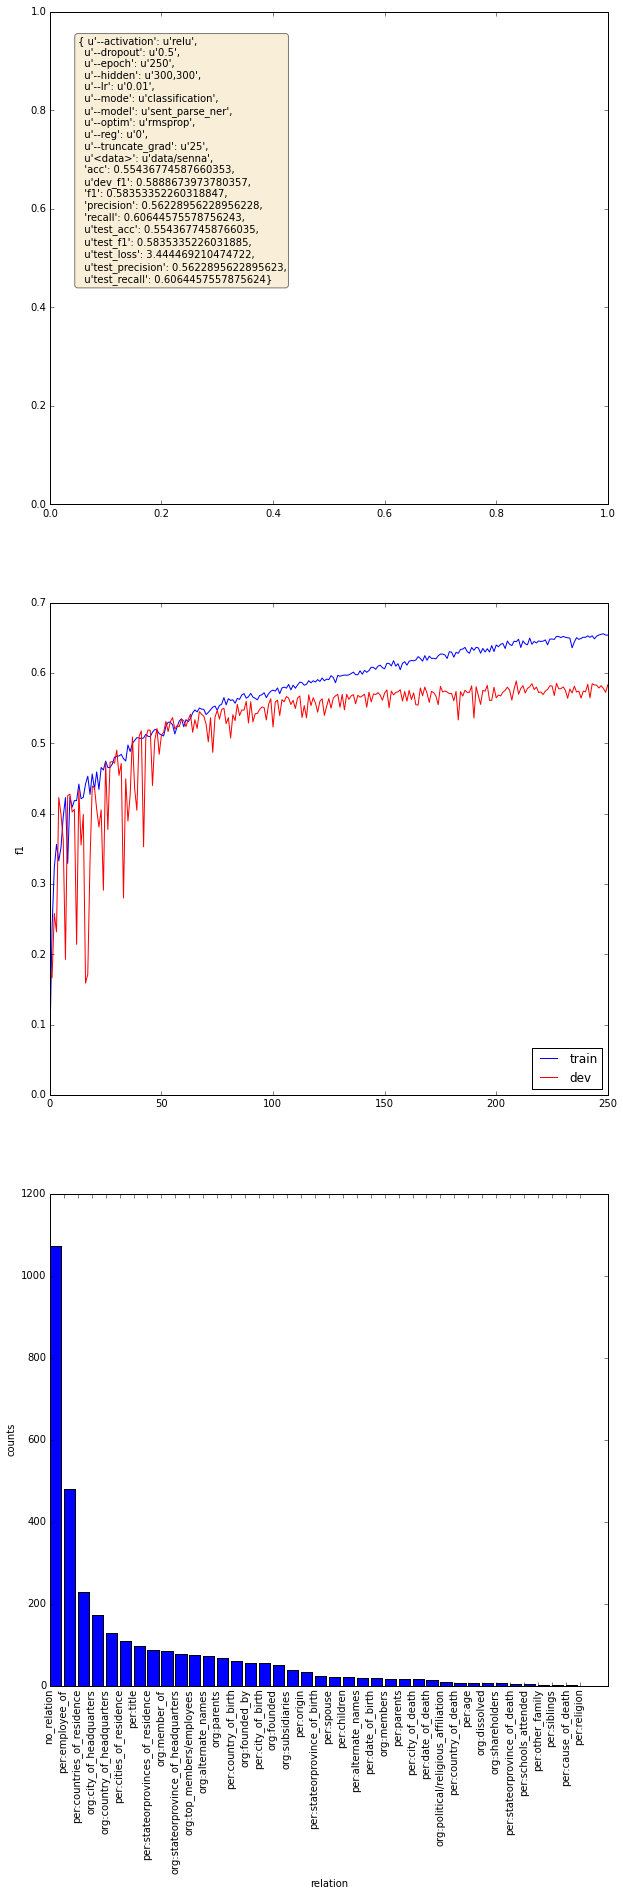

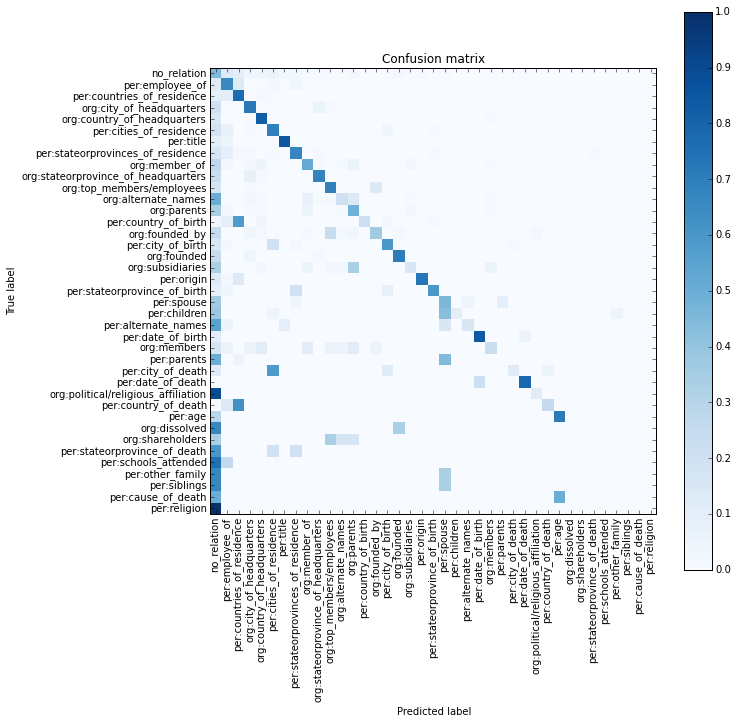

In [46]:
P.close('all')
print_experiment(classification_dir)